In [26]:
import glob
from timeit import default_timer as timer

import torch
import clip
from PIL import Image

import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.special

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [28]:
# CONSTANTS
"""
Choose accordingly to the Model/Dataset being evaluated:
MODEL= {ViT-B-32, ViT-B-16, RN50, RN101, ViT-L-14, RN50x16} 
DATASET= {ISIC_2018}
"""

MODEL = "RN50x16"
DATASET = "ISIC_2018"
ADDITIONAL_COMMENTS = "CONCEPT_PROMPTS"

In [29]:
CONCEPT_PROMPTS = {
    "Asymmetry": ["This is dermatoscopy of an asymmetry"],
    "Irregular": ["This is dermatoscopy of irregular"],
    "Erosion": ["This is dermatoscopy of erosion"],
    "Black": ["This is dermatoscopy of black"],
    "Blue": ["This is dermatoscopy of blue"],
    "White": ["This is dermatoscopy of white"],
    "Brown": ["This is dermatoscopy of brown"],
    "Multiple Colors": ["This is dermatoscopy of multiple colors"],
    "Tiny": ["This is dermatoscopy of tiny"],
    "Regular": ["This is dermatoscopy of a regular"]
}

In [30]:
def calculate_similarity_score(image_features_norm,
                               prompt_target_embedding_norm,
                               prompt_ref_embedding_norm,
                               temp=1,
                               top_k=-1,
                               normalize=True):
    """
    Similarity Score used in "Fostering transparent medical image AI via an image-text foundation model grounded in medical literature"
    https://www.medrxiv.org/content/10.1101/2023.06.07.23291119v1.full.pdf
    """
    
    target_similarity = prompt_target_embedding_norm.float() @ image_features_norm.T.float()
    ref_similarity = prompt_ref_embedding_norm.float() @ image_features_norm.T.float()


    if top_k > 0:
        idx_target = target_similarity.argsort(dim=1, descending=True)
        target_similarity_mean = target_similarity[:,idx_target.squeeze()[:top_k]].mean(dim=1)
        
        ref_similarity_mean = ref_similarity.mean(dim=1)
    else:
        target_similarity_mean = target_similarity.mean(dim=1)
        ref_similarity_mean = ref_similarity.mean(dim=1)
    
    if normalize:
        similarity_score = scipy.special.softmax([target_similarity_mean.numpy(), ref_similarity_mean.numpy()], axis=0)[0, :].mean(axis=0)
    else:
        similarity_score = target_similarity_mean.mean(axis=0)

    return similarity_score

In [36]:
print(f"[INFO] DATASET: {DATASET}")
print(f"[INFO] MODEL: {MODEL}")
SEED = 0

# Load image embeddings 
#img_embeddings = np.load(f"img_embeddings/ISIC_2018/image_embeddings_{DATASET}_{MODEL}-Fine-Tuned_Segmented_Norm.npy", allow_pickle=True).item()
img_embeddings = np.load(f"output/{MODEL}/image_embeddings/image_embeddings__{DATASET}_{MODEL}-Fine-Tuned_{SEED}.npy", allow_pickle=True).item()


# Load reference embeddings
#reference_embeddings = torch.from_numpy(np.load(f"reference_embeddings/ISIC_2018/reference_embeddings_{DATASET}_{MODEL}-Fine-Tuned_{SEED}.npy")).unsqueeze(0)
reference_embeddings = torch.from_numpy(np.load(f"output/{MODEL}/text_embeddings/reference_embeddings__{DATASET}_{MODEL}-Fine-Tuned_{SEED}.npy")).unsqueeze(0)

# Weights of Melanoma (Fig. 5 (I) of reference [16])
weights_melanoma = np.array([[1.9, 2.0, 3.84, 1.6, 0.15, 0.0, 2.4, 8.66, -0.05, -0.15]])

results = dict()
concept_predictions = dict()
# Iterate over images and calculate similarity
for im in img_embeddings.keys():
    img_feats = torch.from_numpy(img_embeddings[im]).unsqueeze(0)

    similarity_scores = []
    for disease_label in CONCEPT_PROMPTS.keys():
        # Load text embeddings of concepts
        #text_feats = torch.from_numpy(np.load(f"text_embeddings/ISIC_2018/concept_embeddings_{disease_label}_{DATASET}_{MODEL}-Fine-Tuned_Segmented.npy")).unsqueeze(0)
        text_feats = torch.from_numpy(np.load(f"output/{MODEL}/text_embeddings/concept_embeddings_{disease_label}_{DATASET}_{MODEL}-Fine-Tuned_{SEED}.npy")).unsqueeze(0)

        # Calculate similarity
        similarity = calculate_similarity_score(image_features_norm=img_feats,
                                                prompt_target_embedding_norm=text_feats,
                                                prompt_ref_embedding_norm=reference_embeddings,
                                                top_k=-1,
                                                temp=(1/np.exp(4.5944)),
                                                normalize=False)

        similarity_scores.append(similarity[0])

    # Calculate prediction given weights of melanoma
    y_pred = np.dot(weights_melanoma, np.array(similarity_scores))
    concept_predictions[im] = np.array(similarity_scores)
    results[im] = y_pred

[INFO] DATASET: ISIC_2018
[INFO] MODEL: RN50x16


In [37]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, balanced_accuracy_score, auc
import pandas

if DATASET == "PH2":
    gt = pd.read_csv("../data/PH2_dataset.csv")
    
    train_images_df = pd.read_csv("../data/PH2_train.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("../data/PH2_validation.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("../data/PH2_test.csv")
    test_images = test_images_df["images"].tolist()

elif DATASET == "derm7pt":
    gt = pd.read_csv("../data/image_classes_derm7pt.csv")
    
    train_images_df = pd.read_csv("../data/derm7pt_train_seg.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("../data/derm7pt_validation_seg.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("../data/derm7pt_test_seg.csv")
    test_images = test_images_df["images"].tolist()

elif DATASET == "ISIC_2018":
    gt = pd.read_csv("../data/ISIC_2018/image_classes_ISIC_2018.csv")
    
    train_images_df = pd.read_csv("../data/ISIC_2018/ISIC_2018_train.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("../data/ISIC_2018/ISIC_2018_validation.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("../data/ISIC_2018/ISIC_2018_test.csv")
    test_images = test_images_df["images"].tolist()

y_true_val = []
y_pred_probs_val = []
for im in results.keys():

    if str(im) in validation_images:
        if DATASET == "ISIC_2018":
            y_true_val.append(1 if gt.loc[gt['images'] == str(im)]['labels'].tolist()[0] == 3 else 0)
        else:
            y_true_val.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred_probs_val.append(results[im])

fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_probs_val)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold, "\n")

y_true = []
y_pred = []
y_pred_probs = []
for im in results.keys():
    
    if str(im) in test_images:
        if DATASET == "ISIC_2018":
            y_true.append(1 if gt.loc[gt['images'] == str(im)]['labels'].tolist()[0] == 3 else 0)
        else:
            y_true.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred.append(1 if results[im] > optimal_threshold else 0)
        y_pred_probs.append(results[im])

print("Classification Report:")
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=["MEL", "NEV"]))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]

print("Confusion Matrix:")
print(conf_matrix, "\n")

# Calculate AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# BACC
bacc = balanced_accuracy_score(y_true, y_pred)
print(f"BACC: {bacc}")

# Sensitivity
SE = TP / (TP + FN)
print(f"Sensitivity: {SE}")

# Specificity
SP = TN / (TN + FP)
print(f"Specificity: {SP}")

Threshold value is: -5.498136677592992 

Classification Report:
              precision    recall  f1-score   support

         MEL       0.97      0.62      0.76      1340
         NEV       0.22      0.83      0.35       171

    accuracy                           0.64      1511
   macro avg       0.59      0.73      0.55      1511
weighted avg       0.88      0.64      0.71      1511

Confusion Matrix:
[[832 508]
 [ 29 142]] 

AUC: 0.7458191498647115
BACC: 0.7256524395566029
Sensitivity: 0.8304093567251462
Specificity: 0.6208955223880597


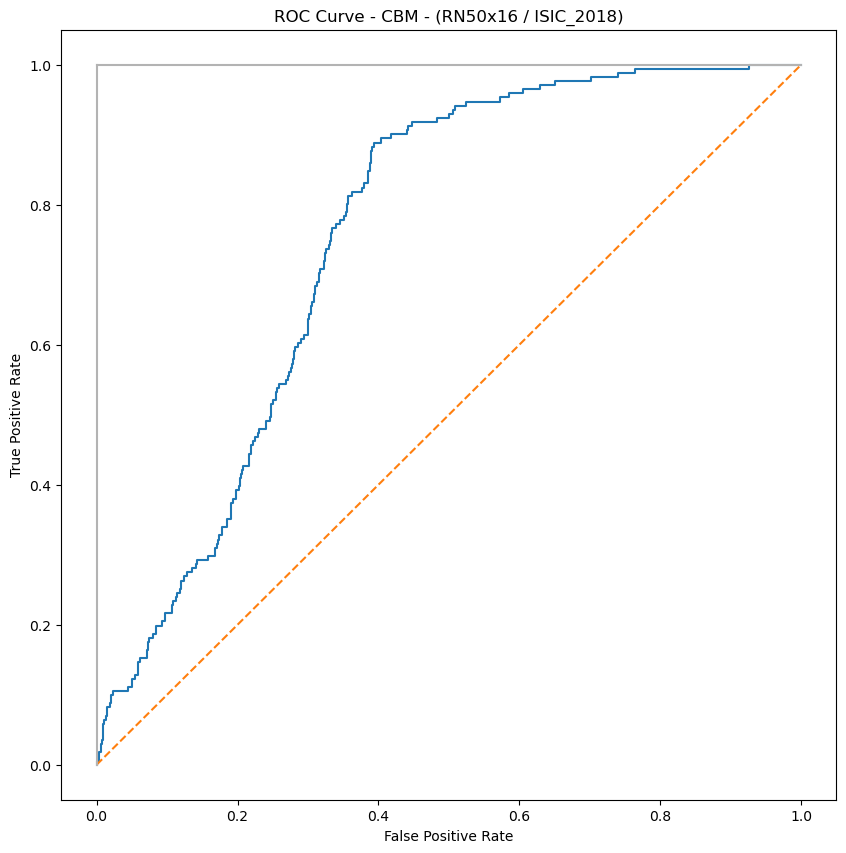

In [33]:
# Plot ROC AUC curve
import matplotlib.pyplot as plt

plt.subplots(1, figsize=(10,10))
plt.title(f'ROC Curve - CBM - ({MODEL} / {DATASET})')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()